# 3.3 "Um contra Todos"

Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
from sklearn.metrics import (confusion_matrix,
precision_recall_curve,
classification_report,
accuracy_score,
mean_squared_error,
mean_absolute_error)
from sklearn.preprocessing import MinMaxScaler
from numpy import linalg as LA
import warnings
warnings.filterwarnings('ignore')

Datasets

In [2]:
train_redu = pd.read_csv('dataset/train_redu.csv')
test_redu = pd.read_csv('dataset/test_redu.csv')

Construindo vetores

In [3]:
X_train = [(x,y) for x, y in zip(train_redu['intensidade'], train_redu['simetria'])]
y_train_initial = train_redu['label']

X_test = [(x,y) for x, y in zip(test_redu['intensidade'], test_redu['simetria'])]
y_test = test_redu['label']

In [4]:
X_train = np.array(X_train)
y_train_initial = np.array(y_train_initial)
X_test = np.array(X_test)
y_test_initial = np.array(y_test)

Funções sobre filtragem de classes

In [5]:
classes = np.unique(y_train_initial)

def classe_digito(digi, y_train = y_train_initial):

    # digi é o digito q eu quero usar no 1 para todos naquele momento

    y_train_bin = np.where(y_train == digi, 1, -1)

    return y_train_bin
    

# Perceptron 

- Tem que ser max_iter = n de pontos
- Guardar a melhor solução
- w pode comecar com 0 ou random

A linha de decisão é dada pela equação: $w_1x_1+w_2x_2+b=0$, onde $w_1 e w_2$​ são os pesos e b é o viés.

$h(x) = sign(w^Tx)$

$w=w+y_ix_i$

In [6]:
class PocketPla():
    def __init__(self, max_iter):
        self.max_iter = max_iter
        self.best_w = None
        self.best_eIN = np.inf
        self.iterations = 0

    def constroiListaPCI(self, X, y, w):
        return np.where(np.sign(X @ w) != y)[0]
    
    def predict(self, _X):
        X = np.column_stack((np.ones(len(_X)), _X))
        return np.sign(np.dot(X, self.best_w))
    
    def fit(self, X, y):
        X = np.column_stack((np.ones(len(X)), X)) # adição do bias
        w = np.zeros(3)  
        self.best_w = w.copy()

        for _ in range(self.max_iter):
            self.iterations += 1
            listaPCI = self.constroiListaPCI(X, y, w)
            error_count = len(listaPCI)

            if error_count < self.best_eIN:
                self.best_eIN = error_count
                self.best_w = w.copy()

            if error_count == 0:
                break

            i = np.random.choice(listaPCI)  # índice aleatório da lista PCI
            w += y[i] * X[i]  # atualização do vetor de pesos

        return self
    
    def plot_decision_boundary(self, X, y, digi, color = 'black',plot=True):

        if plot:
            plt.figure(figsize=(8, 6))

        x1_min, x1_max = min(X[:, 0]), max(X[:, 0])
        
        x2_min = - (self.best_w[0] + self.best_w[1] * x1_min) / self.best_w[2]
        x2_max = - (self.best_w[0] + self.best_w[1] * x1_max) / self.best_w[2]
        plt.plot([x1_min, x1_max], [x2_min, x2_max], label=f'$g_{digi}$', color = color, linestyle='--')

        if plot:

            plt.scatter(X[y == 1, 0], X[y == 1, 1], color='red', label=1)
            plt.scatter(X[y == -1, 0], X[y == -1, 1], color='blue', label=-1)

            plt.xlabel('Intensidade')
            plt.ylabel('Simetria')
            plt.title(f'Função Alvo - Pocket PLA para o dígito {digi}')
            plt.legend()
            plt.xlim(min(X[:, 0]) - 1, max(X[:, 0]) + 1)
            plt.ylim(0, 200)
            plt.show()



Plotar

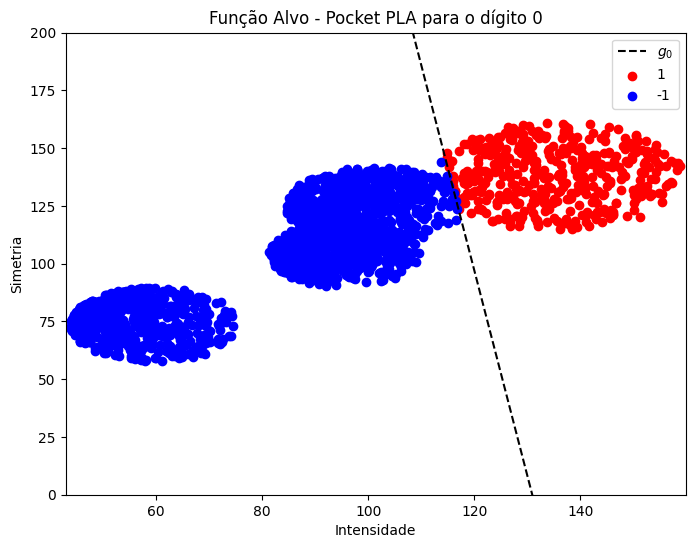

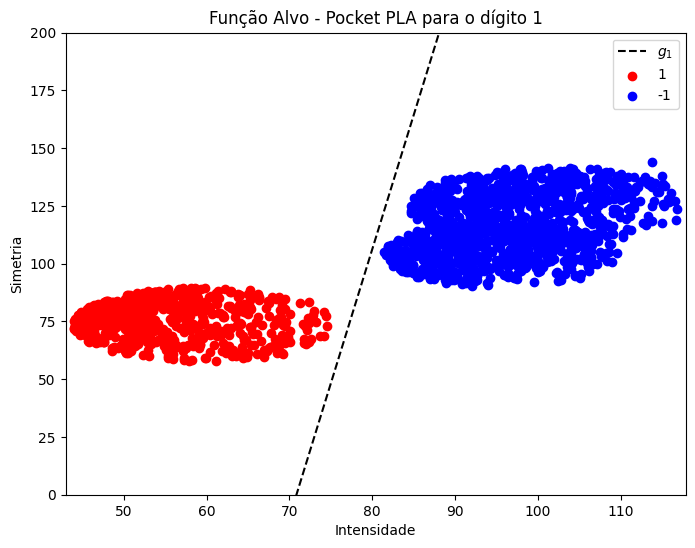

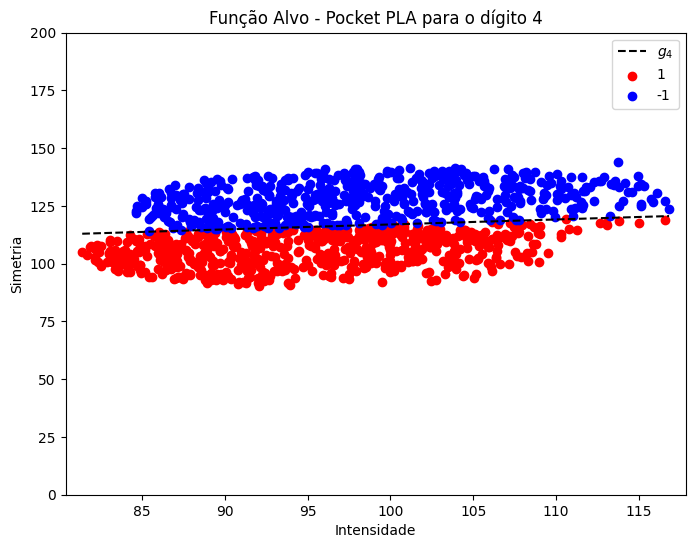

In [7]:
def classificar_sequencialmente(digitos, X_train, y_train_initial):

    resultados = {} 
    indices_restantes = np.arange(X_train.shape[0])  
    iteracoes = 2000000

    for digito in digitos:

        y_train_bin = classe_digito(digito, y_train_initial[indices_restantes])
        
        PLA = PocketPla(iteracoes)
        PLA.fit(X_train[indices_restantes], y_train_bin)
        
        y_pred = PLA.predict(X_train[indices_restantes])
        
        resultados[digito] = {
            "modelo": PLA,
            "y_pred_treino": y_pred,
            "indices": indices_restantes
        }

        PLA.plot_decision_boundary(X_train[indices_restantes], y_pred, digito)

        indices_restantes = indices_restantes[np.where(y_pred == -1)[0]]
        iteracoes -= 100000 # reduzir o número de iteracoes para os próximos dígitos
        

    return resultados

digitos = [0,1,4]

resultados = classificar_sequencialmente(digitos, X_train, y_train_initial)


Funções Hipótese

In [8]:
PLA_0 = resultados[0]['modelo']
PLA_1 = resultados[1]['modelo']
PLA_4 = resultados[4]['modelo']


def f_0(x):
    return PLA_0.predict(x)

def f_1(x):
    return PLA_1.predict(x)

def f_4(x):
    return PLA_4.predict(x)

def f(x):
    x = x.reshape(1, -1)  # garante que x tenha duas dimensões
    if f_0(x) == 1:
        return 0
    elif f_1(x) == 1:
        return 1
    elif f_4(x) == 1:
        return 4
    else:
        return 5



In [9]:
predictions_PLA_test = [f(x) for x in X_test]
predictions_PLA_train = [f(x) for x in X_train]

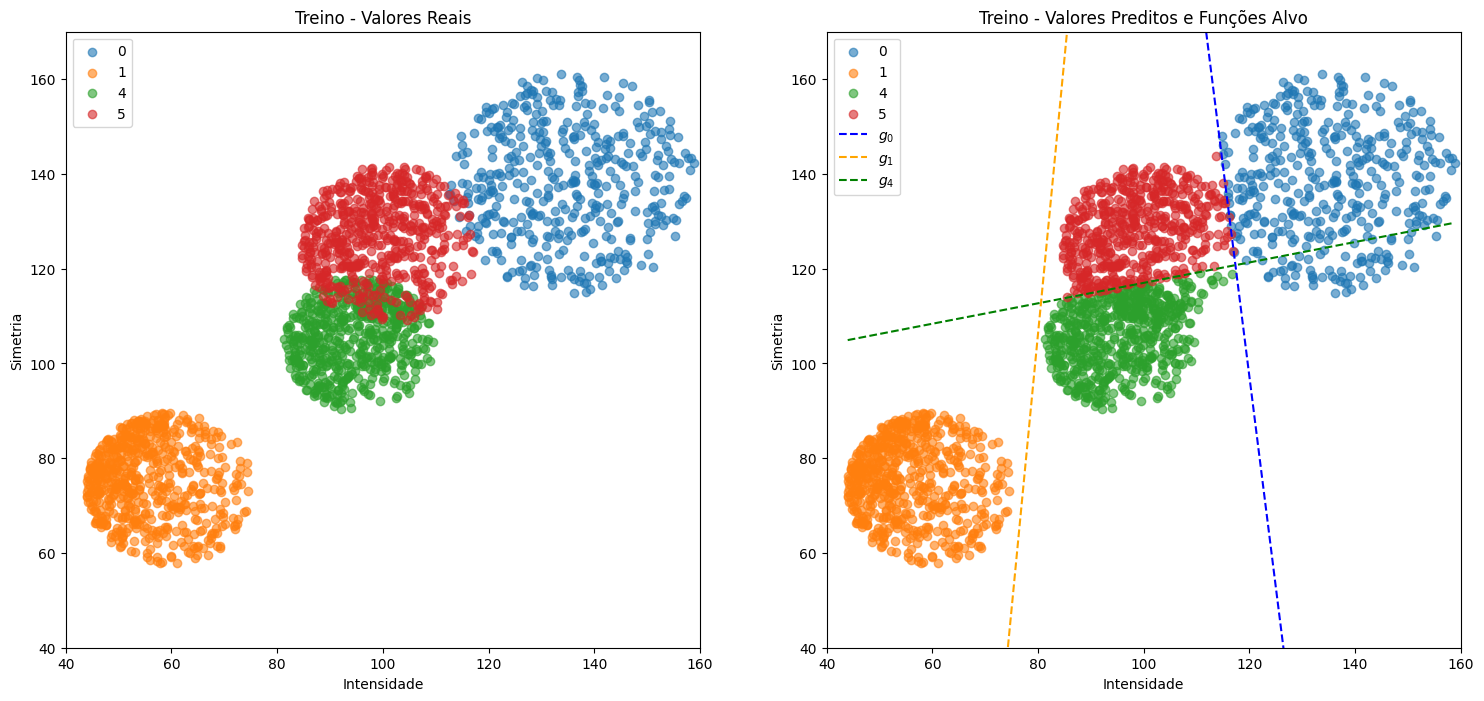

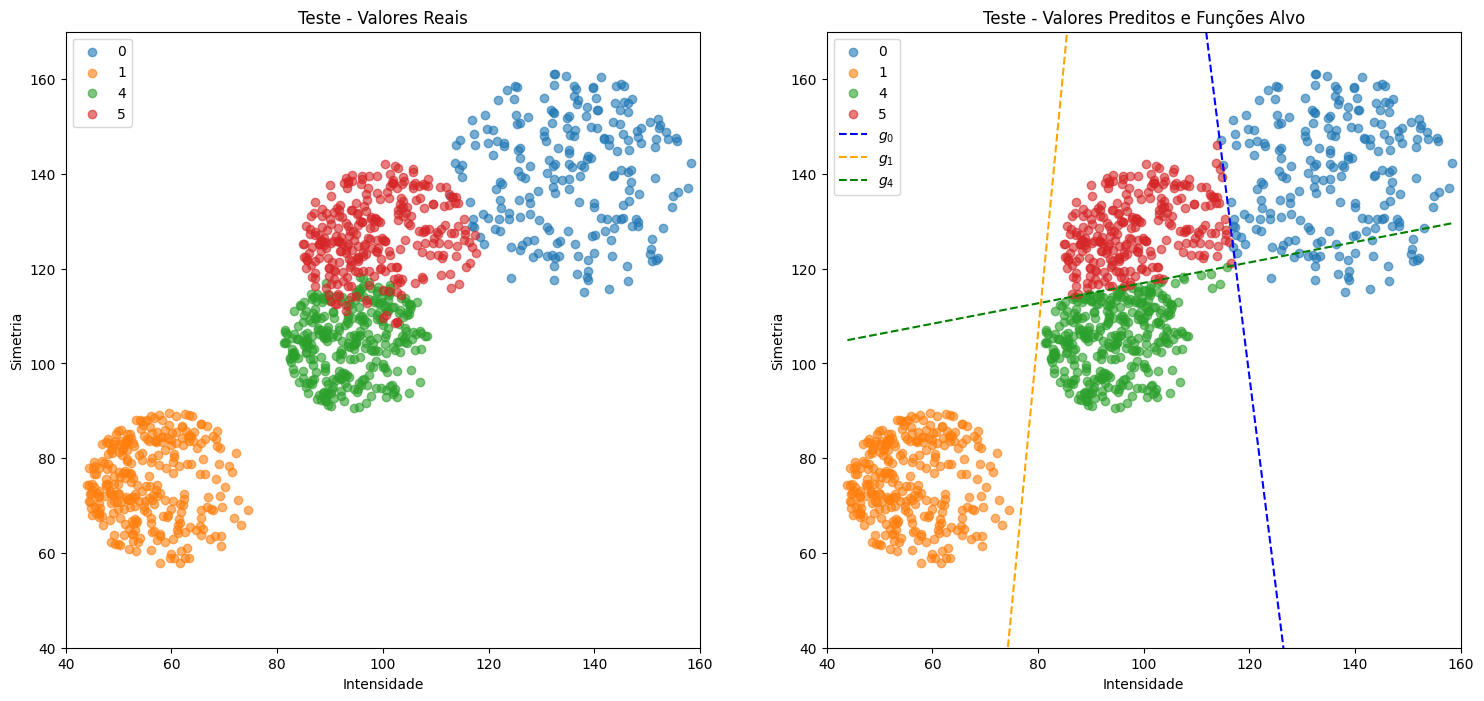

In [44]:
def plotar_comparacao(resultados, X, y_real, y_pred, title):

    fig, ax = plt.subplots(1, 2, figsize=(18, 8))

    colors = itertools.cycle(['blue', 'orange', 'green'])

    for label in np.unique(y_real):
        ax[0].scatter(X[y_real == label][:, 0], X[y_real == label][:, 1], label=f'{label}', alpha=0.6)
    ax[0].set_title(f'{title} - Valores Reais')
    ax[0].set_xlabel('Intensidade')
    ax[0].set_ylabel('Simetria')
    ax[0].legend()
    ax[0].set_xlim(40, 160)
    ax[0].set_ylim(40, 170)

    for label in np.unique(y_pred):
        ax[1].scatter(X[y_pred == label][:, 0], X[y_pred == label][:, 1], label=f'{label}', alpha=0.6)
    for digito, res in resultados.items():
        modelo = res['modelo']
        color = next(colors)
        modelo.plot_decision_boundary(X, np.where(y_pred == digito, 1, -1), digito,color=color, plot=False)
    ax[1].set_title(f'{title} - Valores Preditos e Funções Alvo')
    ax[1].set_xlabel('Intensidade')
    ax[1].set_ylabel('Simetria')
    ax[1].legend()
    ax[1].set_xlim(40, 160)
    ax[1].set_ylim(40, 170)

    plt.show()


plotar_comparacao(resultados, X_train, y_train_initial, predictions_PLA_train, 'Treino')

plotar_comparacao(resultados, X_test, y_test_initial, predictions_PLA_test, 'Teste')


Métricas

Matriz de Confusão

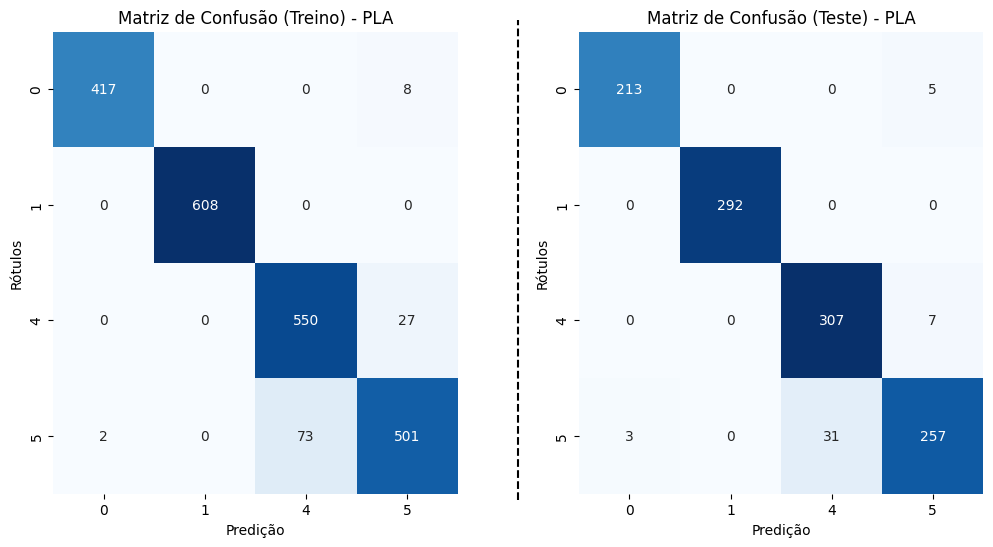

In [11]:
cm_train = confusion_matrix(y_train_initial, predictions_PLA_train)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(cm_train, ax = ax[0], annot=True, fmt='d', cmap='Blues', cbar = False,
            xticklabels=['0','1','4','5'], 
            yticklabels=['0','1','4','5'])
ax[0].set_xlabel('Predição')
ax[0].set_ylabel('Rótulos')
ax[0].set_title('Matriz de Confusão (Treino) - PLA')




cm_teste = confusion_matrix(y_test, predictions_PLA_test)
sns.heatmap(cm_teste, ax = ax[1], annot=True, fmt='d', cmap='Blues', cbar = False,
            xticklabels=['0','1','4','5'], 
            yticklabels=['0','1','4','5'])
ax[1].set_xlabel('Predição')
ax[1].set_ylabel('Rótulos')
ax[1].set_title('Matriz de Confusão (Teste) - PLA')

plt.subplots_adjust(wspace=0.3)

# Adicionando uma linha vertical entre os dois subplots
line_x = (ax[0].get_position().x1 + ax[1].get_position().x0) / 2
fig.add_artist(plt.Line2D([line_x, line_x], [0.1, 0.9], color='black', linestyle='--'))

plt.show()


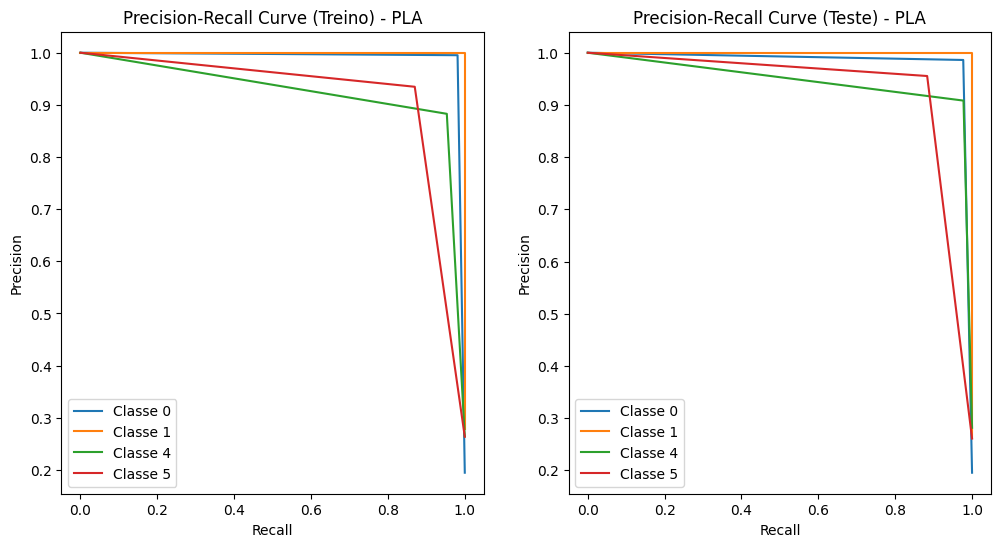

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))


for class_label in np.unique(y_train_initial):
    y_true_binary = (y_train_initial == class_label).astype(int)
    y_pred_binary = (predictions_PLA_train == class_label).astype(int)

    precision, recall, thresholds = precision_recall_curve(y_true_binary, y_pred_binary)
    
    ax[0].plot(recall, precision, label=f'Classe {class_label}')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title('Precision-Recall Curve (Treino) - PLA')
ax[0].legend()

for class_label in np.unique(y_test):
    y_true_binary = (y_test == class_label).astype(int)
    y_pred_binary = (predictions_PLA_test == class_label).astype(int)

    precision, recall, thresholds = precision_recall_curve(y_true_binary, y_pred_binary)
    
    plt.plot(recall, precision, label=f'Classe {class_label}')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve (Teste) - PLA')
ax[1].legend()
plt.show()



In [13]:
from IPython.display import display, Latex

e_in = (PLA_0.best_eIN + PLA_1.best_eIN + PLA_4.best_eIN) / X_train.shape[0]
e_out = 1 - accuracy_score(y_test, predictions_PLA_test)

# Formatando os valores como strings LaTeX
e_in_latex = f'Erro de classificação no treino: $e_{{in}}$ = {e_in:.2%}'
e_out_latex = f'Erro de classificação no teste: $e_{{out}}$ = {e_out:.2%}'

# Exibindo como LaTeX
display(Latex(e_in_latex))
display(Latex(e_out_latex))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [14]:
accur_in = accuracy_score(y_train_initial, predictions_PLA_train)
accur_out = accuracy_score(y_test, predictions_PLA_test)

print(f'Acurácia no treino: {accur_in:.2%}')
print(f'Acurácia no teste: {accur_out:.2%}')

Acurácia no treino: 94.97%
Acurácia no teste: 95.87%


In [15]:
bold_start = "\033[1m"
bold_end = "\033[0m"

print(f"{bold_start}Classification Report do Treino:{bold_end}\n")
print(classification_report(y_train_initial, predictions_PLA_train))
print(f"{bold_start}Classification Report do Teste:{bold_end}\n")
print(classification_report(y_test, predictions_PLA_test))


Classification Report do Treino:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       425
           1       1.00      1.00      1.00       608
           4       0.88      0.95      0.92       577
           5       0.93      0.87      0.90       576

    accuracy                           0.95      2186
   macro avg       0.95      0.95      0.95      2186
weighted avg       0.95      0.95      0.95      2186

Classification Report do Teste:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       218
           1       1.00      1.00      1.00       292
           4       0.91      0.98      0.94       314
           5       0.96      0.88      0.92       291

    accuracy                           0.96      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.96      0.96      0.96      1115



# Regressão Linear

vetor de pesos $w=(X^TX)^{-1}X^Ty$

In [16]:
class LinearRegression():
    def __init__(self):
        self.w = None

    def getW(self):
        return self.w
    
    def fit(self, _X, _y):
        s = _X.shape[0]
        X = np.column_stack((np.ones(s), _X))
        self.w = np.linalg.inv(X.T @ X) @ X.T @ _y
        return self
    
    def predict(self, _X):
        if self.w is None:
            raise Exception('Modelo não treinado')
        s = _X.shape[0]
        X = np.column_stack((np.ones(s), _X))
        return X @ self.w
    

class LRClassifier():
    def execute(self, _X, _y):
        lr = LinearRegression()
        lr.fit(_X, _y)
        self.w = lr.getW()
                
    def predict(self, x_):
        return np.sign(np.dot(np.insert(x_, 0, 1,axis=1), self.w))
     
    def getRegressionY(self, regressionX, shift=0):
        return (-self.w[0]+shift - self.w[1]*regressionX) / self.w[2]
    

    def plot_g(self, X, y, digi, color = 'black',plot=True):

        if plot:
            plt.figure(figsize=(8, 6))

        x1_min, x1_max = min(X[:, 0]), max(X[:, 0])
        
        x2_min = - (self.w[0] + self.w[1] * x1_min) / self.w[2]
        x2_max = - (self.w[0] + self.w[1] * x1_max) / self.w[2]
        plt.plot([x1_min, x1_max], [x2_min, x2_max], label=f'$g_{digi}$', color = color, linestyle='--')

        if plot:

            plt.scatter(X[y == 1, 0], X[y == 1, 1], color='red', label=1)
            plt.scatter(X[y == -1, 0], X[y == -1, 1], color='blue', label=-1)

            plt.xlabel('Intensidade')
            plt.ylabel('Simetria')
            plt.title(f'Função Alvo - Regressão Linear para o dígito {digi}')
            plt.legend()
            plt.xlim(min(X[:, 0]) - 1, max(X[:, 0]) + 1)
            plt.ylim(0, 200)
            plt.show()

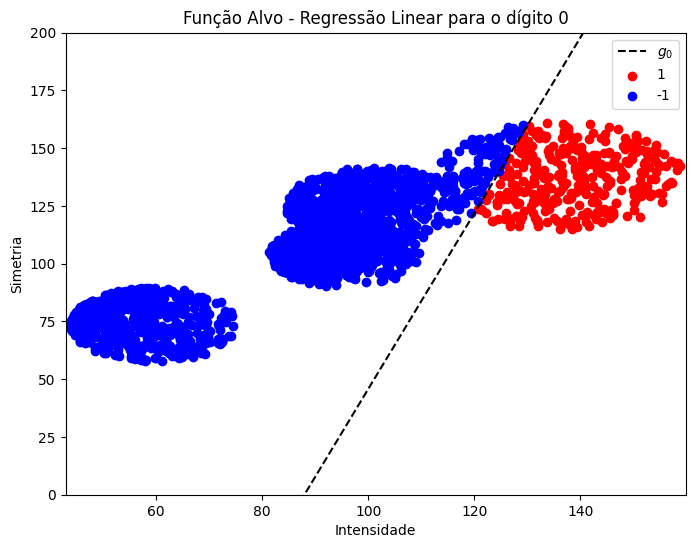

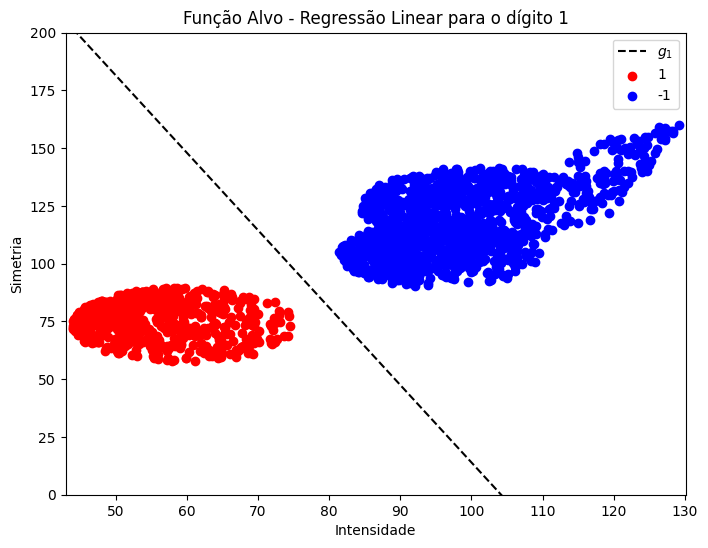

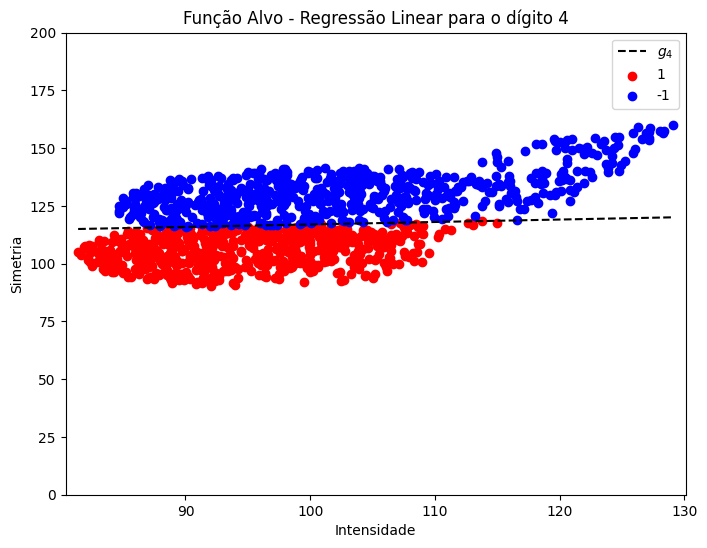

In [17]:
def classificar_LRC(digitos, X_train, y_train_initial):

    resultados = {}  
    indices_restantes = np.arange(X_train.shape[0]) 

    for digito in digitos:

        y_train_bin = classe_digito(digito, y_train_initial[indices_restantes])
        
        LRC = LRClassifier()
        LRC.execute(X_train[indices_restantes], y_train_bin)
        
        y_pred = LRC.predict(X_train[indices_restantes])
        
        resultados[digito] = {
            "modelo": LRC,
            "y_pred": y_pred,
            "indices": indices_restantes
        }

        LRC.plot_g(X_train[indices_restantes], y_pred, digito)

        indices_restantes = indices_restantes[np.where(y_pred == -1)[0]]
        
    return resultados

digitos = [0,1,4]

resultados_LRC = classificar_LRC(digitos, X_train, y_train_initial)


Funções Hipótese

In [18]:
LRC_0 = resultados_LRC[0]['modelo']
LRC_1 = resultados_LRC[1]['modelo']
LRC_4 = resultados_LRC[4]['modelo']

def f_0(x):
    return LRC_0.predict(x)

def f_1(x):
    return LRC_1.predict(x)

def f_4(x):
    return LRC_4.predict(x)

def f_LRC(x):
    x = x.reshape(1, -1)  
    if f_0(x) == 1:
        return 0
    elif f_1(x) == 1:
        return 1
    elif f_4(x) == 1:
        return 4
    else:
        return 5

In [19]:
predictions_LRC_test = [f_LRC(x) for x in X_test]
predictions_LRC_train = [f_LRC(x) for x in X_train]

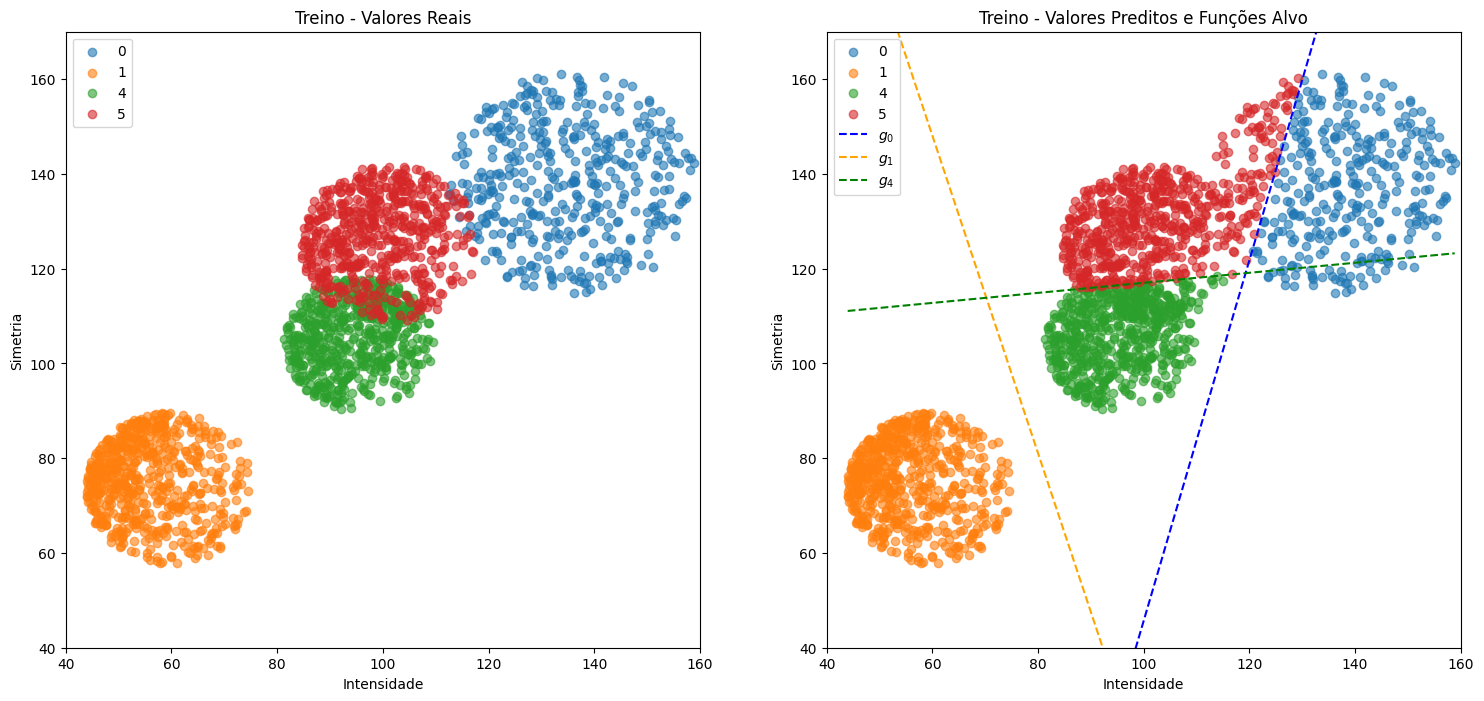

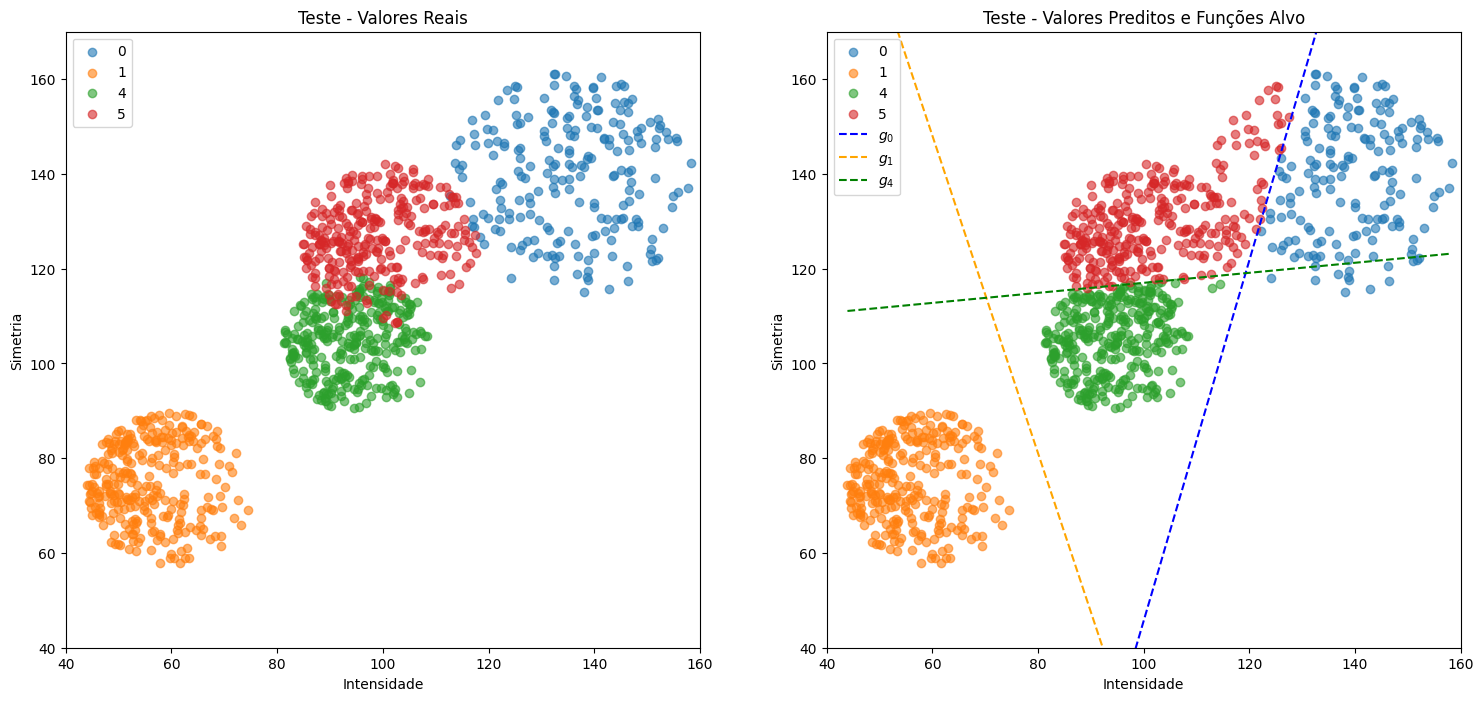

In [43]:
def plotar_comparacao_LRC(resultados, X, y_real, y_pred, title):

    fig, ax = plt.subplots(1, 2, figsize=(18, 8))

    colors = itertools.cycle(['blue', 'orange', 'green'])

    for label in np.unique(y_real):
        ax[0].scatter(X[y_real == label][:, 0], X[y_real == label][:, 1], label=f'{label}', alpha=0.6)
    ax[0].set_title(f'{title} - Valores Reais')
    ax[0].set_xlabel('Intensidade')
    ax[0].set_ylabel('Simetria')
    ax[0].legend()
    ax[0].set_xlim(40, 160)
    ax[0].set_ylim(40, 170)

    for label in np.unique(y_pred):
        ax[1].scatter(X[y_pred == label][:, 0], X[y_pred == label][:, 1], label=f'{label}', alpha=0.6)
    for digito, res in resultados.items():
        modelo = res['modelo']
        color = next(colors)
        modelo.plot_g(X, np.where(y_pred == digito, 1, -1), digito,color=color, plot=False)
    ax[1].set_title(f'{title} - Valores Preditos e Funções Alvo')
    ax[1].set_xlabel('Intensidade')
    ax[1].set_ylabel('Simetria')
    ax[1].legend()
    ax[1].set_xlim(40, 160)
    ax[1].set_ylim(40, 170)

    plt.show()


plotar_comparacao_LRC(resultados_LRC, X_train, y_train_initial, predictions_LRC_train, 'Treino')

plotar_comparacao_LRC(resultados_LRC, X_test, y_test_initial, predictions_LRC_test, 'Teste')


Métricas

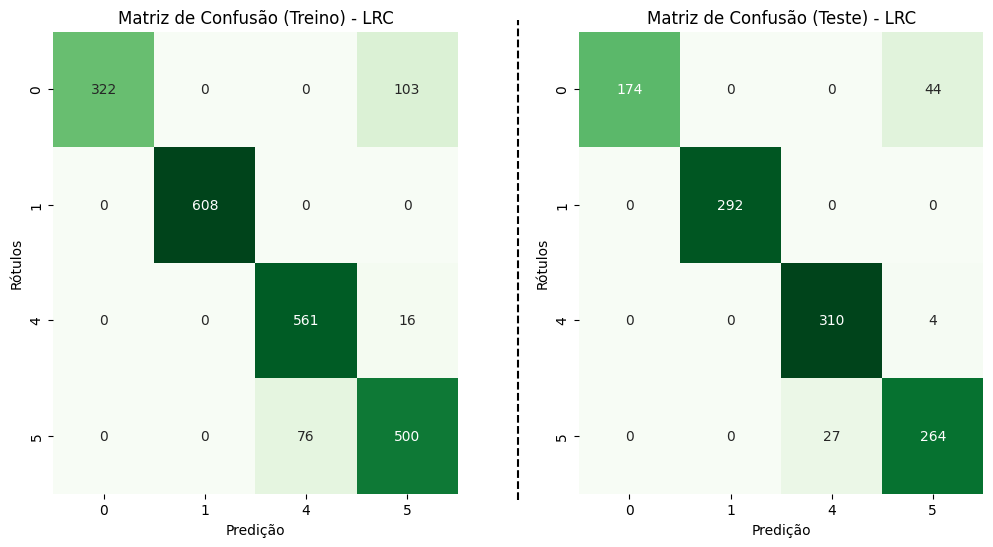

In [21]:
cm_train_LRC = confusion_matrix(y_train_initial, predictions_LRC_train)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(cm_train_LRC, ax = ax[0], annot=True, fmt='d', cmap='Greens', cbar = False,
            xticklabels=['0','1','4','5'], 
            yticklabels=['0','1','4','5'])
ax[0].set_xlabel('Predição')
ax[0].set_ylabel('Rótulos')
ax[0].set_title('Matriz de Confusão (Treino) - LRC')




cm_teste_LRC = confusion_matrix(y_test, predictions_LRC_test)
sns.heatmap(cm_teste_LRC, ax = ax[1], annot=True, fmt='d', cmap='Greens', cbar = False,
            xticklabels=['0','1','4','5'], 
            yticklabels=['0','1','4','5'])
ax[1].set_xlabel('Predição')
ax[1].set_ylabel('Rótulos')
ax[1].set_title('Matriz de Confusão (Teste) - LRC')

plt.subplots_adjust(wspace=0.3)

# Adicionando uma linha vertical entre os dois subplots
line_x = (ax[0].get_position().x1 + ax[1].get_position().x0) / 2
fig.add_artist(plt.Line2D([line_x, line_x], [0.1, 0.9], color='black', linestyle='--'))

plt.show()


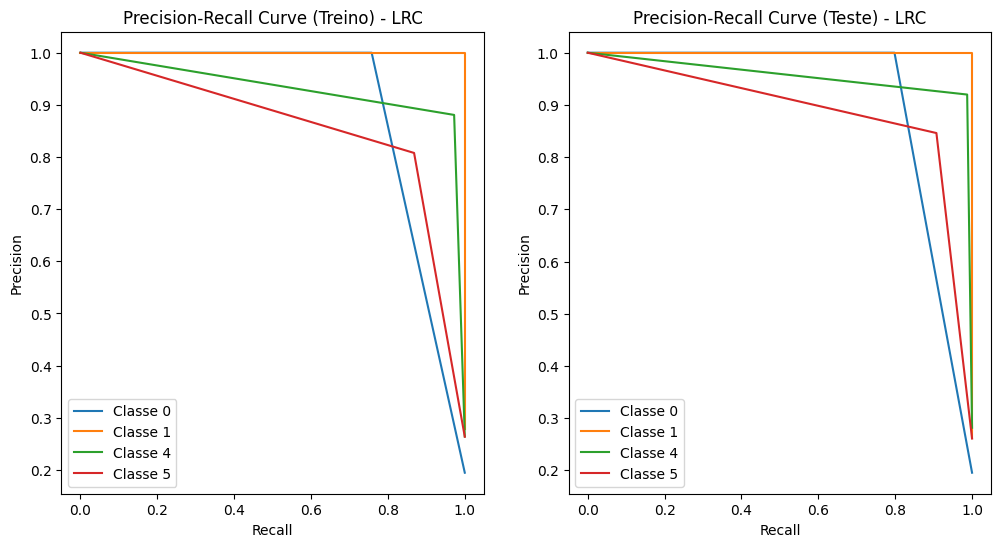

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))


for class_label in np.unique(y_train_initial):
    y_true_binary = (y_train_initial == class_label).astype(int)
    y_pred_binary = (predictions_LRC_train == class_label).astype(int)

    precision, recall, thresholds = precision_recall_curve(y_true_binary, y_pred_binary)
    
    ax[0].plot(recall, precision, label=f'Classe {class_label}')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title('Precision-Recall Curve (Treino) - LRC')
ax[0].legend()

for class_label in np.unique(y_test):
    y_true_binary = (y_test == class_label).astype(int)
    y_pred_binary = (predictions_LRC_test == class_label).astype(int)

    precision, recall, thresholds = precision_recall_curve(y_true_binary, y_pred_binary)
    
    plt.plot(recall, precision, label=f'Classe {class_label}')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve (Teste) - LRC')
ax[1].legend()
plt.show()




In [23]:
from IPython.display import display, Latex

e_in = 1 - accuracy_score(y_train_initial, predictions_LRC_train)
e_out = 1 - accuracy_score(y_test, predictions_LRC_test)

# Formatando os valores como strings LaTeX
e_in_latex = f'Erro de classificação no treino: $e_{{in}}$ = {e_in:.2%}'
e_out_latex = f'Erro de classificação no teste: $e_{{out}}$ = {e_out:.2%}'

# Exibindo como LaTeX
display(Latex(e_in_latex))
display(Latex(e_out_latex))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [24]:
accur_in = accuracy_score(y_train_initial, predictions_LRC_train)
accur_out = accuracy_score(y_test, predictions_LRC_test)

print(f'Acurácia no treino: {accur_in:.2%}')
print(f'Acurácia no teste: {accur_out:.2%}')

Acurácia no treino: 91.08%
Acurácia no teste: 93.27%


In [25]:
bold_start = "\033[1m"
bold_end = "\033[0m"

print(f"{bold_start}Classification Report do Treino:{bold_end}\n")
print(classification_report(y_train_initial, predictions_LRC_train))
print(f"{bold_start}Classification Report do Teste:{bold_end}\n")
print(classification_report(y_test, predictions_LRC_test))


Classification Report do Treino:

              precision    recall  f1-score   support

           0       1.00      0.76      0.86       425
           1       1.00      1.00      1.00       608
           4       0.88      0.97      0.92       577
           5       0.81      0.87      0.84       576

    accuracy                           0.91      2186
   macro avg       0.92      0.90      0.91      2186
weighted avg       0.92      0.91      0.91      2186

Classification Report do Teste:

              precision    recall  f1-score   support

           0       1.00      0.80      0.89       218
           1       1.00      1.00      1.00       292
           4       0.92      0.99      0.95       314
           5       0.85      0.91      0.88       291

    accuracy                           0.93      1115
   macro avg       0.94      0.92      0.93      1115
weighted avg       0.94      0.93      0.93      1115



# Logistic Regression

### Normalização

In [26]:
scaler = MinMaxScaler()

#ajusta e transforma
train_redu_scaled = scaler.fit_transform(train_redu.drop('label', axis=1)) 
#transforma para evitar vazamento
test_redu_scaled = scaler.transform(test_redu.drop('label', axis=1)) 

train_redu['i_normalizada'] = train_redu_scaled[:,0]
train_redu['s_normalizada'] = train_redu_scaled[:,1]

test_redu['i_normalizada'] = test_redu_scaled[:,0]
test_redu['s_normalizada'] = test_redu_scaled[:,1]

In [27]:
#para testes
y_train_orig = train_redu['label']
y_test_orig = test_redu['label']

#normalizando
x_train = np.hstack((np.ones((len(train_redu), 1)), train_redu[['i_normalizada', 's_normalizada']].values))

x_test = np.hstack((np.ones((len(test_redu), 1)), test_redu[['i_normalizada', 's_normalizada']].values))
y_test = np.array([1 if y_ == 0 else -1 for y_ in test_redu['label']])


#escalonando
x_train_orig = scaler.inverse_transform(train_redu[['i_normalizada', 's_normalizada']].values)
x_train_orig = np.hstack((np.ones((len(train_redu), 1)), x_train_orig))

x_test_orig = scaler.inverse_transform(test_redu[['i_normalizada', 's_normalizada']].values)
x_test_orig = np.hstack((np.ones((len(test_redu), 1)), x_test_orig))

### Classes

In [28]:
class RegressaoLogistica():

    def __init__(self, learning_rate = 0.1, iterations = 10000, bs = 12):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.batch_size = bs

    def sigmoide(self, x):
        return 1/(1 + np.exp(-x))        

    def fit(self, X, Y):
        
        X = np.array(X)
        Y = np.array(Y)

        #numero de amostras
        m = X.shape[0]
        
        #numero de features
        n = X.shape[1]

        W = np.zeros(n, dtype = float)

        self.W = []
        
        
        for i in range(self.iterations):
            
            #vetor acumulador dos gradientes
            v_g = np.zeros(n, dtype = float)

            
            #caso o lote seja menor, escolher aleatoriamente uma nova mini-amostra
            if self.batch_size < m:

                indices = random.sample(range(m), self.batch_size)

                batch_x = [X[j] for j in indices]
                batch_y = [Y[j] for j in indices]

            else:
                batch_x = X
                batch_y = Y

            
            for x_, y_ in zip(batch_x, batch_y):
                
                #gradiente dos pesos atuais com sigmoide inversa
                v_g += (y_ * x_) / (1 + np.exp((y_ * W).T @ x_))

            #gradiente medio
            g_m = v_g / self.batch_size

            #condição de parada
            if LA.norm(g_m) < 0.0001:
                break

            #atualiza os pesos
            W += self.learning_rate * g_m

        self.W = W

    def predict(self, X):
        
        #probabilidade
        Z = np.dot(X, self.W)
        prob = np.exp(Z) / (1 + np.exp(Z))
                
        y_pred = np.where(prob >= 0.5, 1, -1)

        return y_pred
    
    def normaliza_y(self, x, shift = 0):
        return (-self.W[0] + shift - self.W[1] * x) / self.W[2]

In [29]:
def novo_df(X, y_pred):
  indices_to_keep = []
  for i in range(len(X)):
    if(np.array(y_pred[i]) == -1):
      indices_to_keep.append(i)
  return X.iloc[indices_to_keep]

In [30]:
def plot(x_or, y_pred, data, modelo):

    xmin = x_or[:,1].min()
    xmax = x_or[:,1].max()

    sns.scatterplot(x='intensidade', y='simetria', hue=y_pred, data=data, palette='coolwarm', s=5)

    x = np.linspace(xmin, xmax, 100)

    x_normalized = scaler.transform(np.column_stack((x, np.zeros_like(x))))[:, 0]
    y_normalized = modelo.normaliza_y(x_normalized)

    y = scaler.inverse_transform(np.column_stack((x, y_normalized)))[:, 1]

    plt.plot(x, y, 'y-', label='g(.)')
    plt.legend(loc='upper right')
    plt.title(f'Função Alvo - Regressão Linear')
    plt.show()

In [31]:
def um_tds(train_redu, digitos=[0, 1, 4]):

    modelos = {}

    for i in digitos:
        
        x_train = train_redu[['i_normalizada', 's_normalizada']].values
        x_train = np.hstack((np.ones((len(x_train), 1)), x_train))

        y_train_norm = np.array([1 if y_ == i else -1 for y_ in train_redu['label']])

        x_train_orig = scaler.inverse_transform(train_redu[['i_normalizada', 's_normalizada']].values)
        x_train_orig = np.hstack((np.ones((len(train_redu), 1)), x_train_orig))

        rl = RegressaoLogistica()
        rl.fit(x_train, y_train_norm)
        y_pred_train = rl.predict(x_train)

        plot(x_train_orig, y_pred_train, train_redu, rl)

        modelos[i] = rl

        train_redu = novo_df(train_redu, y_pred_train)

    return modelos


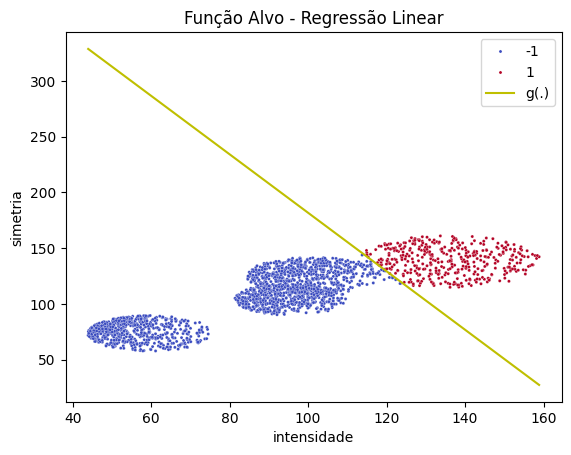

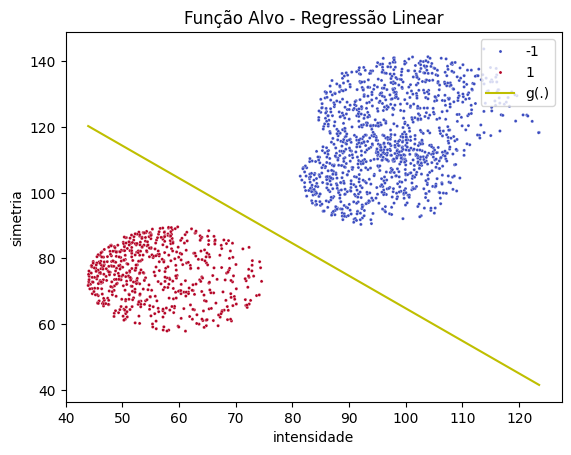

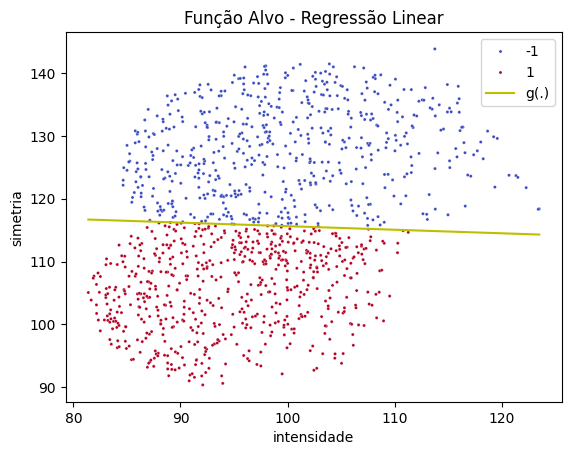

In [32]:
modelos = um_tds(train_redu)

### Funções Hipótese

In [33]:
def classe_0(x):
    pred = modelos[0].predict(x)
    return np.array(pred)

def classe_1(x):
    pred = modelos[1].predict(x)
    return np.array(pred)

def classe_4(x):
    pred = modelos[4].predict(x)
    return np.array(pred)

def classificador(x):
    if classe_0(x) == 1:
        return 0
    elif classe_1(x) == 1:
        return 1
    elif classe_4(x) == 1:
        return 4
    else:
        return 5  

In [34]:
pred_treino = [classificador(x) for x in x_train]
pred_teste = [classificador(x) for x in x_test]

### Vizualização Gráfica

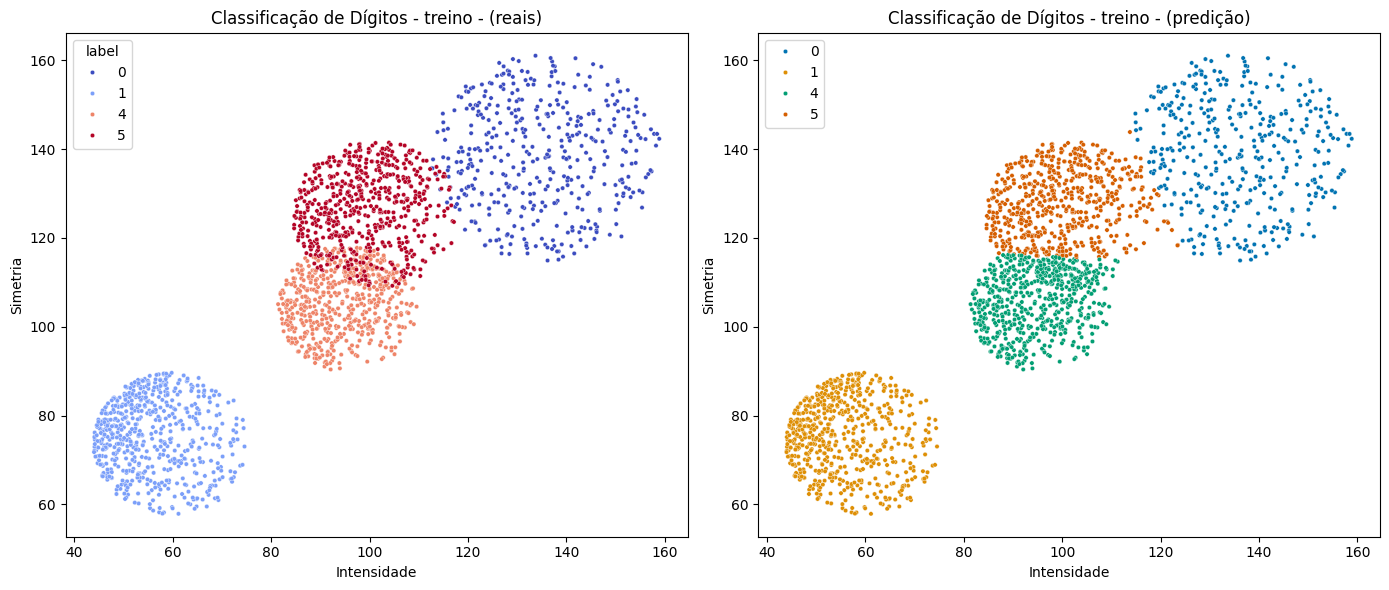

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(ax=axes[0], x='intensidade', y='simetria', hue=train_redu['label'], data=train_redu, palette='coolwarm', s=10, marker='o')
axes[0].set_title('Classificação de Dígitos - treino - (reais)')
axes[0].set_xlabel('Intensidade')
axes[0].set_ylabel('Simetria')

sns.scatterplot(ax=axes[1], x='intensidade', y='simetria', hue=pred_treino, data=train_redu, palette='colorblind', s=10, marker='o')
axes[1].set_title('Classificação de Dígitos - treino - (predição)')
axes[1].set_xlabel('Intensidade')
axes[1].set_ylabel('Simetria')

plt.tight_layout()
plt.show()

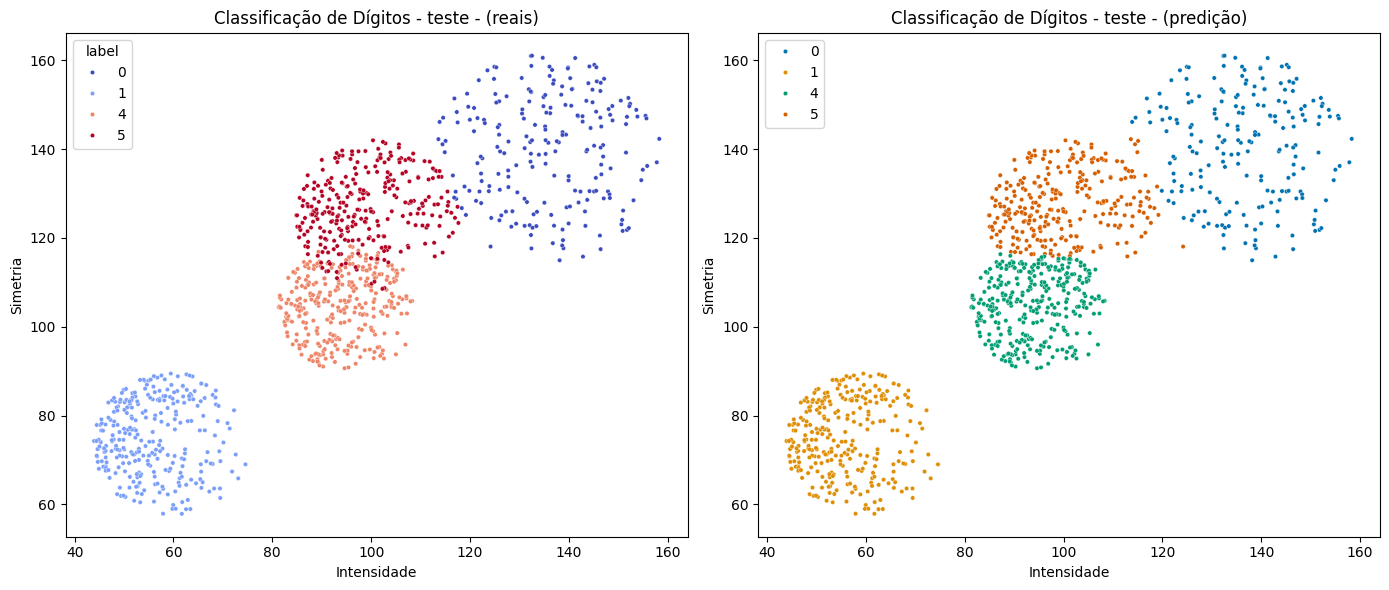

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(ax=axes[0], x='intensidade', y='simetria', hue=test_redu['label'], data=test_redu, palette='coolwarm', s=10, marker='o')
axes[0].set_title('Classificação de Dígitos - teste - (reais)')
axes[0].set_xlabel('Intensidade')
axes[0].set_ylabel('Simetria')

sns.scatterplot(ax=axes[1], x='intensidade', y='simetria', hue=pred_teste, data=test_redu, palette='colorblind', s=10, marker='o')
axes[1].set_title('Classificação de Dígitos - teste - (predição)')
axes[1].set_xlabel('Intensidade')
axes[1].set_ylabel('Simetria')

plt.tight_layout()
plt.show()

Matriz de Confusão

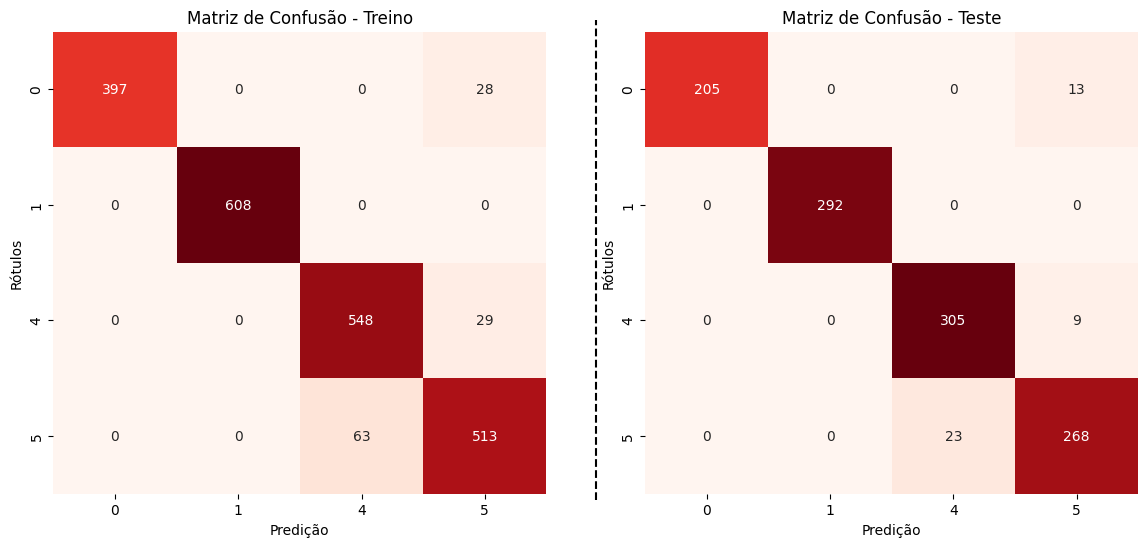

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cm_train = confusion_matrix(y_train_orig, pred_treino)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Reds', cbar = False,
            xticklabels=['0', '1', '4', '5'], 
            yticklabels=['0', '1', '4', '5'], ax=axes[0])
axes[0].set_xlabel('Predição')
axes[0].set_ylabel('Rótulos')
axes[0].set_title('Matriz de Confusão - Treino')



cm_test = confusion_matrix(y_test_orig, pred_teste)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds', cbar = False,
            xticklabels=['0', '1', '4', '5'], 
            yticklabels=['0', '1', '4', '5'], ax=axes[1])
axes[1].set_xlabel('Predição')
axes[1].set_ylabel('Rótulos')
axes[1].set_title('Matriz de Confusão - Teste')

# Adicionando uma linha vertical entre os dois subplots
line_x = (ax[0].get_position().x1 + ax[1].get_position().x0) / 2
fig.add_artist(plt.Line2D([line_x, line_x], [0.1, 0.9], color='black', linestyle='--'))

plt.show()


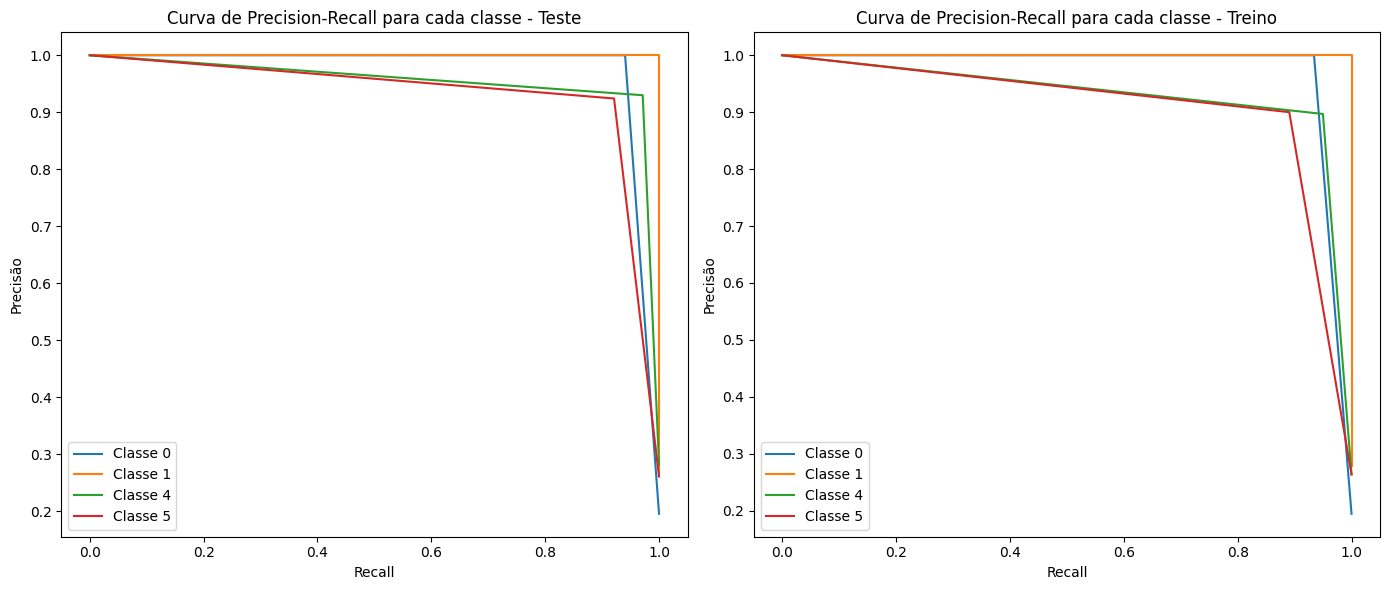

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for class_label in np.unique(y_test_orig):
    y_true_binary = (y_test_orig == class_label).astype(int)
    y_pred_binary = (pred_teste == class_label).astype(int)

    precision, recall, thresholds = precision_recall_curve(y_true_binary, y_pred_binary)
    
    axes[0].plot(recall, precision, label=f'Classe {class_label}')

axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precisão')
axes[0].set_title('Curva de Precision-Recall para cada classe - Teste')
axes[0].legend()

for class_label in np.unique(y_train_orig):
    y_true_binary = (y_train_orig == class_label).astype(int)
    y_pred_binary = (pred_treino == class_label).astype(int)

    precision, recall, thresholds = precision_recall_curve(y_true_binary, y_pred_binary)
    
    axes[1].plot(recall, precision, label=f'Classe {class_label}')

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precisão')
axes[1].set_title('Curva de Precision-Recall para cada classe - Treino')
axes[1].legend()

plt.tight_layout()
plt.show()

## Eficiência da Classificação

In [39]:
pred_treino = np.array(pred_treino)
pred_teste = np.array(pred_teste)

train_accuracy = accuracy_score(y_train_orig.T, pred_treino)
print(f'Acurácia no treino: {train_accuracy*100:.2f}%')

test_accuracy = accuracy_score(y_test_orig.T, pred_teste)
print(f'Acurácia no teste: {test_accuracy*100:.2f}%')

Acurácia no treino: 94.51%
Acurácia no teste: 95.96%


In [40]:
N_in = len(train_redu)
eIn = 0
for i in range(N_in):
    if(pred_treino[i] != train_redu['label'][i]):
        eIn += 1
eIn /= N_in
print("Ein = " + str(eIn))


N_out = len(test_redu)
eOut = 0
for i in range(N_out):
    if(pred_teste[i] != test_redu['label'][i]):
        eOut += 1
eOut /= N_out
print("Eout = " + str(eOut))

Ein = 0.05489478499542543
Eout = 0.04035874439461883


In [41]:
print('Treino:')
print(classification_report(train_redu['label'].tolist(), pred_treino))

print('')

print('Teste:')
print(classification_report(test_redu['label'].tolist(), pred_teste))

Treino:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97       425
           1       1.00      1.00      1.00       608
           4       0.90      0.95      0.92       577
           5       0.90      0.89      0.90       576

    accuracy                           0.95      2186
   macro avg       0.95      0.94      0.95      2186
weighted avg       0.95      0.95      0.95      2186


Teste:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       218
           1       1.00      1.00      1.00       292
           4       0.93      0.97      0.95       314
           5       0.92      0.92      0.92       291

    accuracy                           0.96      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.96      0.96      0.96      1115



In [42]:
print('Metricas de Erro - Treino')
print("Erro médio quadrático: ", mean_squared_error(y_train_orig.T, pred_treino))
print("Erro médio absoluto: ", mean_absolute_error(y_train_orig.T, pred_treino))

print('')

print('Metricas de Erro - Teste')
print("Erro médio quadrático: ", mean_squared_error(y_test_orig.T, pred_teste))
print("Erro médio absoluto: ", mean_absolute_error(y_test_orig.T, pred_teste))

Metricas de Erro - Treino
Erro médio quadrático:  0.36230558096980786
Erro médio absoluto:  0.10612991765782251

Metricas de Erro - Teste
Erro médio quadrático:  0.3201793721973094
Erro médio absoluto:  0.08699551569506726
